# Prediciting particle transport by ocean and wind currents

Sometime about 500 years ago, famed explorer Ferdinand Magellan said: "The sea is dangerous and its storms terrible, but these obstacles have never been sufficient reason to remain ashore." This quote is mainly about respecting the power of the sea, then with unknown powers. Today we are able to measure and even predict its power in ocean and wind currents through numerical simulations. These simulations have mulitple usages, and was for example used to caluclate the trajectory of oilspill after the explosion on the oil platform Deepwater Horizon in 2010. In the future these simulations will remain highly relevant due to the oceans increasing amount of plastics. This report will use recorded data of ocean and wind currents to attempt to implement these simulations to predict the trajectory of plastics at the water surface along the Norwegian coast.

<hr>

In [13]:
# Import necessary libraries

%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from time import time

import xarray as xr
from scipy.interpolate import RectBivariateSpline

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

**(1a)** For these simulations, it is useful to start off with a simple case without the recorded data. This will be done by simulating a velocity field in the $xy$-plane for $x \in \left[0,2\right]$, $y \in \left[0,1\right]$, and then consider particles, $\textbf{r}$, moving in this field. These particles' trajectory will be dependent on the ODE: $$ \dot{\textbf{r}} = [v_x(\textbf{r}, t), v_y(\textbf{r}, t)]$$
Heun's method, a second-order explicit method, will be implemented to solve this ODE. As seen later, the advantage of this ODE-solver is that with known data at only discreet times, $t_n$, the time interval, $h$, can be adjusted to fit with the timeinterval in the known data.

Below are defined necessary constants and functions for solving this ODE. This will be implemented to handle N particles for later use.

In [14]:
#Foreslår flytte konstantene ned, og egt bare slette denne cellen
#Her sto det:

#Define necessary constants

A = 0.1
epsilon = 0.25
omega = 1

In [15]:
#Define necessary constants

A = 0.1
epsilon = 0.25
omega = 1

# Define given functions for simplicty in the ODE
def a(t):
    return epsilon * np.sin(omega * t)

def b(t):
    return 1 - 2 * epsilon * np.sin(omega * t)

def f_a(x, t):
    return a(t) * x**2 + b(t) * x

def fDelX(x, t):
    return 2 * a(t) * x + b(t)

def vX(x, y, t):
    return -np.pi * A * np.sin(np.pi * f_a(x, t)) * np.cos(np.pi * y)

def vY(x, y, t):
    return np.pi * A * np.cos(np.pi * f_a(x, t)) * np.sin(np.pi * y) * fDelX(x, t)

# Final ODE, using the above defined functions
def ODE(coords, t):
    xs = coords[0,:]
    ys = coords[1,:]
    return np.array([vX(xs, ys, t), vY(xs, ys, t)])

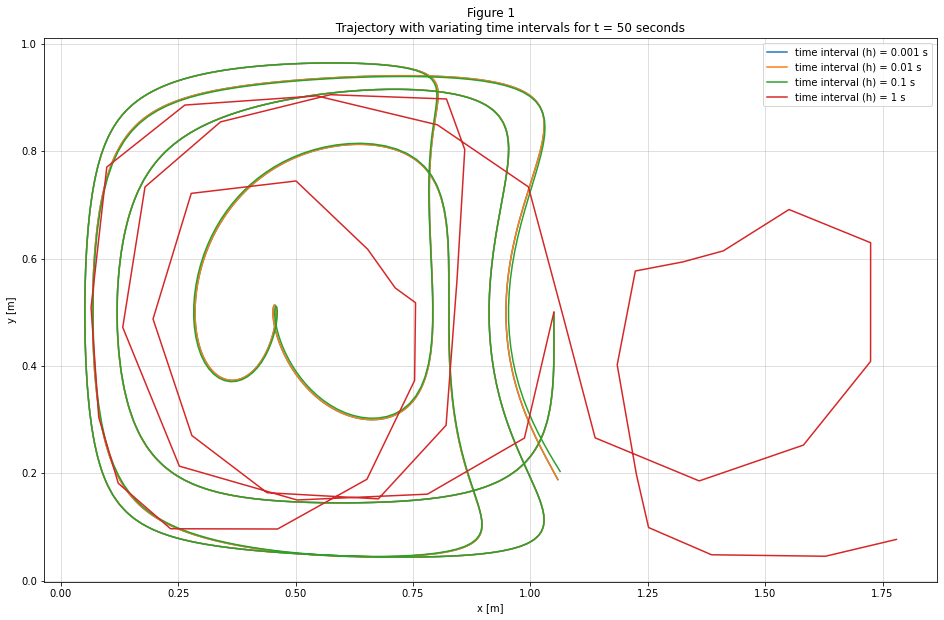

In [16]:
# Implement Heun's method for solving an ODE

def Heun(h, tEnd, initPos, f):
    """Inputs a time interval, stoptime, initial position of the particle, and the given ODE,
    and returns an array with the coordinates of the particles trajectory"""
    
    t = np.arange(0, tEnd, h)

    #Create an empty array of coordinates, and initialise the first position
    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        coordI = coordArr[:,:,i-1]
        ti = t[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = coordI +h/2*(k1 + k2)

    return coordArr

# Plot the trajectory of mulitple particles with variating time intervals
plt.figure(figsize=(16, 10))
plt.title("""Figure 1
          Trajectory with variating time intervals for t = 50 seconds""")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

# Initialise startposition
pos0 = np.zeros((2,1))
pos0[0:,] = 1.05
pos0[1:,] = 0.5

hVals = [0.001, 0.01, 0.1, 1]

for h in hVals:
     trajectory = Heun(h, 50, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"time interval (h) = {h} s")
     plt.grid(alpha=0.5)
     plt.legend()

From **Figur 1** it can be argued that a time interval of about $0.1$ s is a sufficiently short time interval. Generally in stepwise ODE-solvers, the smaller the time interval, the more accurate the simulation is. However, it is also relevant to reduce computing time, and therefore use a larger time intervall, that reduces number of iterations. The curves in #Figur 1# for $h = 0.001$ s, $h = 0.01$ s and $h = 0.1$ s all closely overlap, and it is therefore reasonable to use a time interval of 0.1 s going forward.

The accuracy can of course be related to the total amount of time, and it is therefore relevant to observe if this time interval is just as useful for a total time of 100 s, as done below.

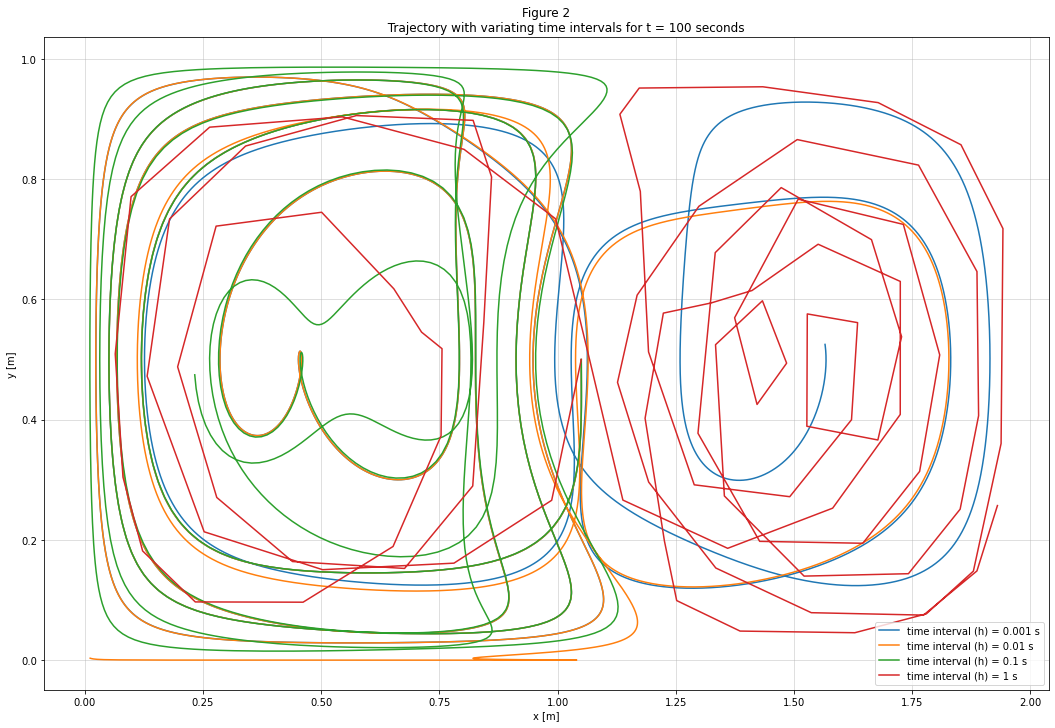

In [17]:
plt.figure(figsize=(18, 12))
plt.title("""Figure 2
          Trajectory with variating time intervals for t = 100 seconds""")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

for h in hVals:
     trajectory = Heun(h, 100, pos0, ODE)
     plt.plot(trajectory[0,0,:], trajectory[1,0,:], label = f"time interval (h) = {h} s")
     plt.grid(alpha=0.5)
     plt.legend()

From **Figure 2** it can be argued that a time interval of 0.1 s might not be sufficiently small enough. As argued above, most ODE-solvers are more accurate the smaller the time interval, and in the figure above the simulation with $h = 0.1$ s does not exhibit the same trajectory as the simulations with smaller time intervals. It is therefore reasonable to use a time interval of $h = 0.01$ s going forward.

It can also be noted that the larger time interval $h = 1$ s exhibit similar trajectories to the smaller ones, but this is likely due to a too big of a time interval, making it's trajectory more random.

**(1b)** It is now natural to observe multiple particles' trajectories in the same, given diffrent inital positions. These positions may be randomized, but it is interesting to observe how particles close to each other behave differently based on a small distance in initial position. This is done below.

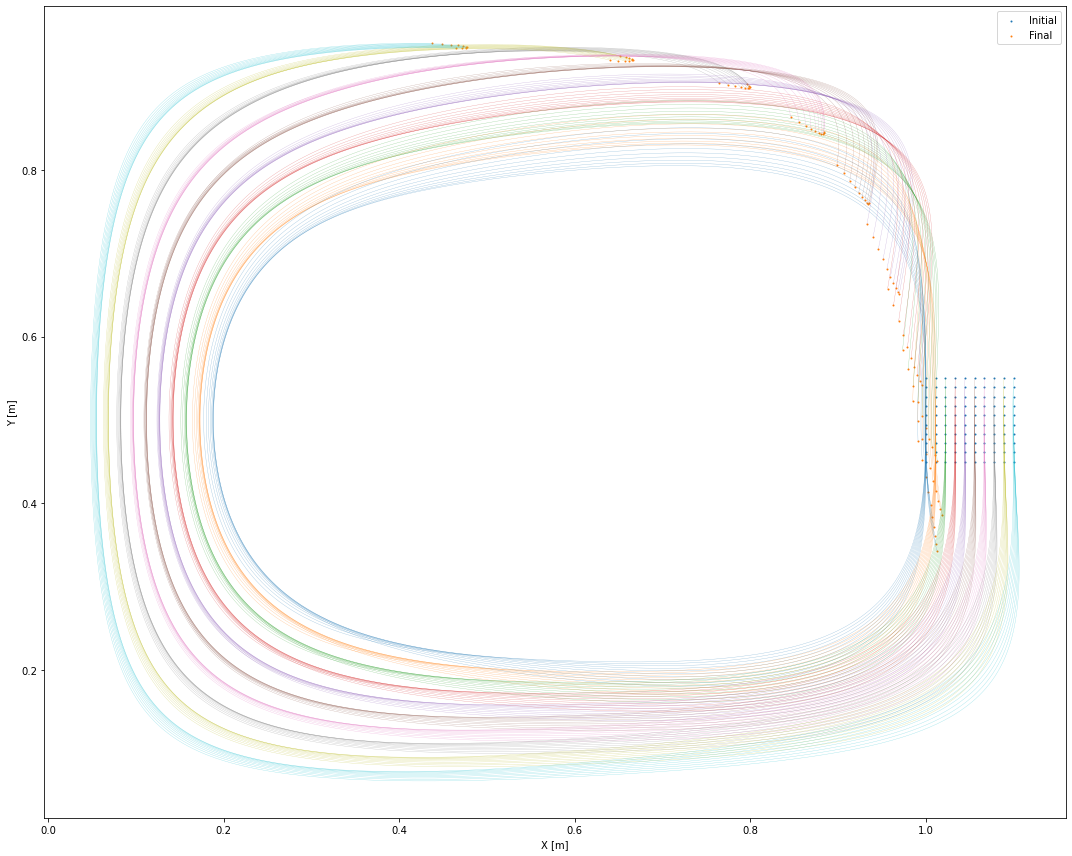

In [18]:
h = 0.01
Np = 100
rows, columns = int(np.sqrt(Np)), int(np.sqrt(Np))

xArr = np.linspace(1, 1.1, rows)
yArr = np.linspace(0.45, 0.55, rows)
X, Y = np.meshgrid(xArr, yArr)

initPositions = np.vstack([X.flatten(), Y.flatten()])

B = Heun(h, 10, initPositions, ODE)

fig = plt.figure(figsize=(15,12))
ax= plt.axes()

ax.scatter(initPositions[0,:], initPositions[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(B[0,i,:],B[1,i,:], lw=0.3, alpha=0.5)
ax.scatter(B[0,:,-1], B[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
plt.tight_layout()

As in **(1a)**, the particles exhibit traits of moving in a circle, as if caught in an ocean- or windstream. It is however apparent that although particles placed close to each other exhibit different types of trajectories, as in the figure above, they might end up quite far away from each other. This can be seen by the difference in distance between the innermost (closest to origo) and the outermost particles before and after the simulation, where they go from a distance of $0.1$ m, to about $0.8$ m apart.

1c)

Text(0, 0.5, 'Time [s]')

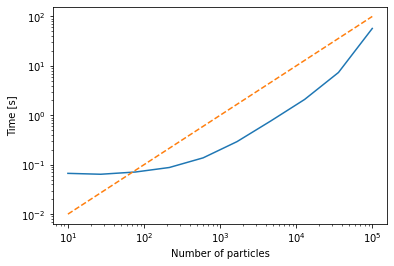

In [19]:
# Test implementation by measuring time to run for different numbers of particles, plot of runtime as function of N_p

N_p_arr = np.logspace(1,5,10, dtype=int)
t_arr = np.zeros(len(N_p_arr))
for i,N_p in enumerate(N_p_arr):
    pos0 = np.zeros((2,N_p))
    pos0[0:,] = np.random.rand(N_p)
    pos0[1:,] = np.random.rand(N_p)

    t0 = time()
    trajectory = Heun(0.01, 10, pos0, ODE)
    t1 = time()
    t_arr[i] = t1 - t0

plt.figure()
plt.loglog(N_p_arr, t_arr)
plt.loglog(N_p_arr, N_p_arr/1000, linestyle="--")
plt.xlabel("Number of particles")
plt.ylabel("Time [s]")

Looking at the figure above, it seems reasonable that the asymptotic runtime of the implementation is linear. However, when $N_p \in [10^1,10^3]$, the running time seems to be constant. This is because the implementation has some overhead, which dominate over the work done for each particle for smaller values for $N_p$

2a) Kommenter at dette er utdelt

In [20]:
#2a
#################################################
#### Convenience class for reading datafiles ####
#################################################

class Interpolator():
    def __init__(self, dataset, fw = 0.03):
        # xarray dataset object
        self.dataset = dataset
        # Windage factor
        self.fw = fw
        # Extract timestamps as number of seconds after the start of the file
        # Saves a bit of bother with dealing with np.datetime objects elsewhere
        self.times = np.array([(t - d.time[0])/np.timedelta64(1, 's') for t in d.time[:]], dtype=np.float64)
        self.depth = np.array(self.dataset.h)
        
    def get_interpolators(self, X, it):
        # Add a buffer of cells around the extent of the particle cloud
        buf  = 10
        # Find extent of particle cloud in terms of indices
        imax = np.searchsorted(self.dataset.X, np.amax(X[0,:])) + buf
        imin = np.searchsorted(self.dataset.X, np.amin(X[0,:])) - buf
        jmax = np.searchsorted(self.dataset.Y, np.amax(X[1,:])) + buf
        jmin = np.searchsorted(self.dataset.Y, np.amin(X[1,:])) - buf
        # Take out subset of array, to pass to
        # interpolation object
        # Fill NaN values (land cells) with 0, otherwise
        # interpolation won't work
        u_current = self.dataset.u[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        v_current = self.dataset.v[it, 0, jmin:jmax, imin:imax].T.fillna(0.0)
        u_wind    = self.dataset.Uwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        v_wind    = self.dataset.Vwind[it, jmin:jmax, imin:imax].T.fillna(0.0)
        # RectBivariateSpline essentially returns a function,
        # which can be called to get value at arbitrary position
        fu_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_current)
        fv_current = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_current)
        fu_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], u_wind)
        fv_wind    = RectBivariateSpline(self.dataset.X[imin:imax], self.dataset.Y[jmin:jmax], v_wind)
        return fu_current, fv_current, fu_wind, fv_wind
    
    def get_time_index(self, t):
        # Get index of largest timestamp smaller than (or equal to) t
        return np.searchsorted(self.times, t, side='right') - 1
    
    def on_land(self, X):
        # Find indices for each particle
        ix_list = np.searchsorted(self.dataset.X, X[0,:])
        iy_list = np.searchsorted(self.dataset.Y, X[1,:])
        # Identify which particles are in cells with depth 5
        # (which for some reason is the smallest depth)
        return np.array([self.depth[iy,ix] == 5.0 for ix, iy in zip(ix_list, iy_list)])

    def __call__(self, X, t):
        # get index of current time in dataset
        it = self.get_time_index(t)
        # get interpolating functions,
        # covering the extent of the particle
        fu_current, fv_current, fu_wind, fv_wind = self.get_interpolators(X, it)
        
        # Evaluate velocity at position(x[:], y[:])
        dx = fu_current(X[0,:], X[1,:], grid = False) + self.fw*fu_wind(X[0,:], X[1,:], grid = False)
        dy = fv_current(X[0,:], X[1,:], grid = False) + self.fw*fv_wind(X[0,:], X[1,:], grid = False)
        return np.array([dx, dy])
    

Tekst om koden under

In [21]:
# Update the file path to where you put the downloaded file
d  = xr.open_dataset('data/NorKyst-800m.nc')
# Initialise the interpolator object with the data
f  = Interpolator(dataset = d, fw =0.03)



# create some positions
mean_x = 790000
mean_y = 490000
standard_dev = 10000

Np = 1000
X = np.zeros((2, Np))
X[0,:] = np.random.normal(loc = mean_x, scale = standard_dev, size = Np)
X[1,:] = np.random.normal(loc = mean_y, scale = standard_dev, size = Np)

E = np.zeros((2,Np))

E = Heun(3600,3600*5*24,X, f)
# scatter plot positions, note the extra transform keyword

FileNotFoundError: [Errno 2] No such file or directory: '/Users/larsengstad/Documents/vitberkrigerene/tekfysprosjekt/data/NorKyst-800m.nc'

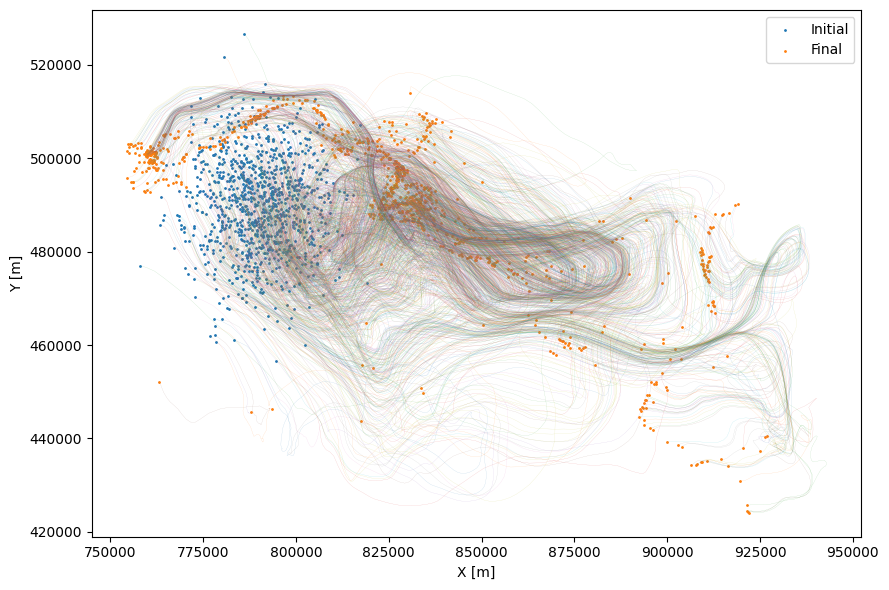

In [ ]:
#Plot i xy-planet

fig = plt.figure(figsize=(9,6))
ax= plt.axes()

ax.scatter(X[0,:], X[1,:], s=1, label='Initial')
for i in range(Np):
    ax.plot(E[0,i,:],E[1,i,:], lw=0.1, alpha=0.5)
ax.scatter(E[0,:,-1], E[1,:,-1], s=1, label='Final')

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend()
plt.tight_layout()

Kommenter plott

2b)

In [ ]:
npstere = ccrs.Stereographic(
    central_latitude = 90,
    central_longitude = f.dataset.projection_stere.straight_vertical_longitude_from_pole,
    false_easting = f.dataset.projection_stere.false_easting,
    false_northing = f.dataset.projection_stere.false_northing,
    true_scale_latitude = f.dataset.projection_stere.standard_parallel,
)


def plottingFunction(number, args, Np, h, time, standard_dev, mean_x, mean_y, ODE=Heun):
    """Function to plot one or more simulations"""
    S = np.zeros((number, 2, Np))
    E = np.zeros((number, 2, Np, time//h))

    for i in range(number):
        S[i, 0, :] = np.random.normal(loc=mean_x[i], scale=standard_dev, size=Np)
        S[i, 1, :] = np.random.normal(loc=mean_y[i], scale=standard_dev, size=Np)
        E[i] = ODE(h, time, S[i,:,:], f)

    fig, axs = plt.subplots(1, number, figsize=(number*6, number*6), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    if number == 1:
        axs = np.array([axs])
    for ax, arg, S_j, E_j in zip(axs, args, S, E):
        s, e, b, t = arg
        ax.set_facecolor('#9CC4CF')
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', color='#a5a48b'))
        ax.scatter(S_j[0, :], S_j[1,:], s=0.7, transform=npstere, label='Initial', color='firebrick', alpha=0.7)

        for i in range(Np):
            ax.plot(E_j[0, i,:], E_j[1, i, :], transform=npstere, lw=0.1, alpha=0.3, color='black')
        
        if (ODE==HeunWithStop):
            final_pos = E_j[:, :,-1]
            afloat = final_pos[:,f.on_land(final_pos)==False]
            stranded = final_pos[:,f.on_land(final_pos)==True]

            ax.scatter(afloat[0,:], afloat[1,:], s=1, transform=npstere, label='afloat', color='mediumseagreen')
            ax.scatter(stranded[0,:], stranded[1,:], s=1, transform=npstere, label='on land', color='blueviolet')
        else:
            ax.scatter(E_j[0, :, -1], E_j[1, :, -1], s=0.7, transform=npstere, label='Final', color='mediumseagreen')
        
        ax.set_extent((s, e, b, t))

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=.5, color='k', lw=.5)
        ax.legend()

    plt.tight_layout()
    return E

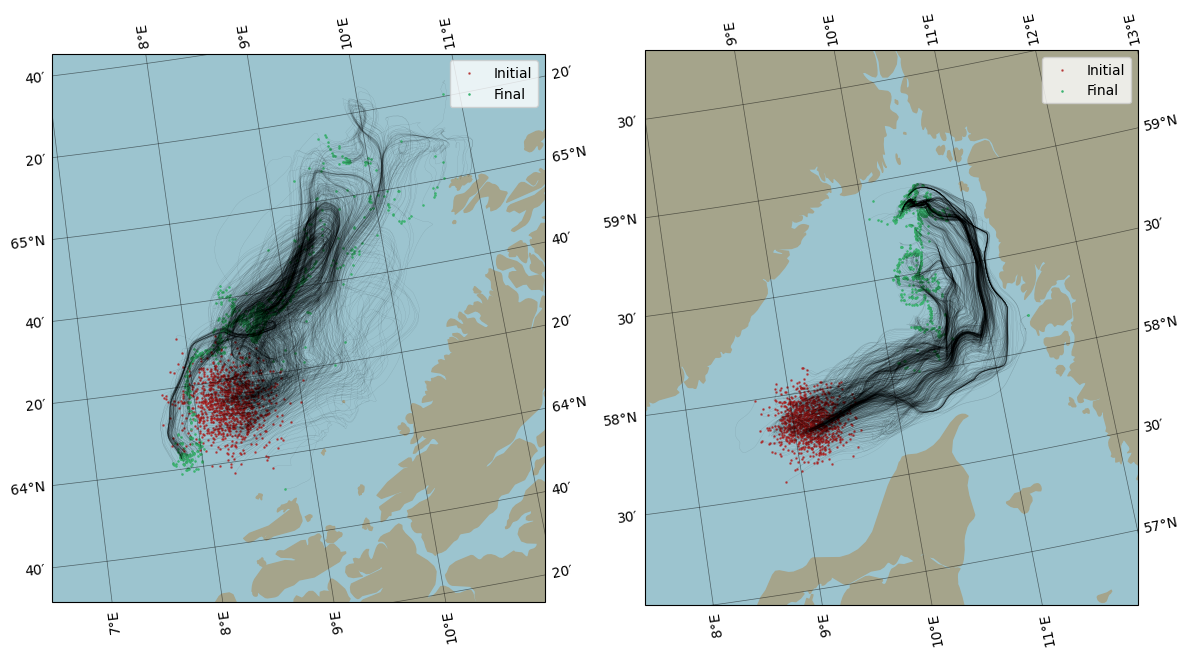

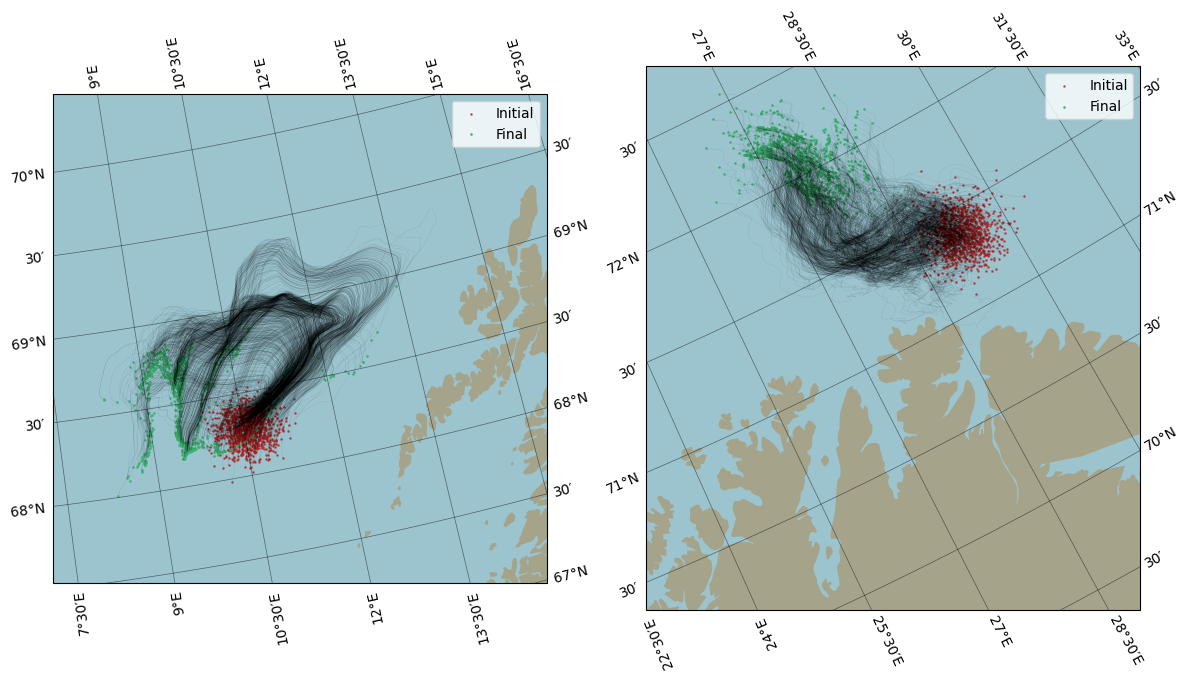

In [ ]:
args1 = ((7, 11, 63.5, 65.5), (8, 12, 59.5, 57))
args2 = ((8, 15, 67.5, 70), (25, 30, 70, 72.2))

mean_x1 = np.array([790000, 190000])
mean_x2 = np.array([1220000, 1915000])

mean_y1 = np.array([490000, 110000])
mean_y2 = np.array([620000, 300000])


plottingFunction(len(mean_x1), args1, 1000, 3600, 3600*24*5, 10000, mean_x1, mean_y1)
plottingFunction(len(mean_x2), args2, 1000, 3600, 3600*24*5, 10000, mean_x2, mean_y2)

Kommenter plott

Tekst

3) Until now, the model has not taken into account that particles might end up hitting land. The function `on_land` from the `Interpolate` class will be used to modify the `Heun` method. The modified implementation, `HeunWithStop`, is given below.

In [ ]:
def HeunWithStop(h, tEnd, initPos, f):
    t = np.arange(0, tEnd, h)

    coordArr = np.zeros((initPos.shape[0],initPos.shape[1],len(t)))
    coordArr[:,:,0] = initPos

    for i in range(1, len(t)):
        coordI = coordArr[:,:,i-1]
        ti = t[i-1]
        k1 = f(coordI, ti)

        tempCoord = coordI + k1*h

        k2 = f(tempCoord, ti + h)

        coordArr[:,:,i] = np.where(f.on_land(coordArr[:,:,i-1]),coordI,coordI +h/2*(k1 + k2))

    return coordArr

3a) The modified method provides the opportunity to examine how many particles strand, as well as where and when they strand. To look into this, we place particles around a point off the coast of Western Norway and simulate their movements.

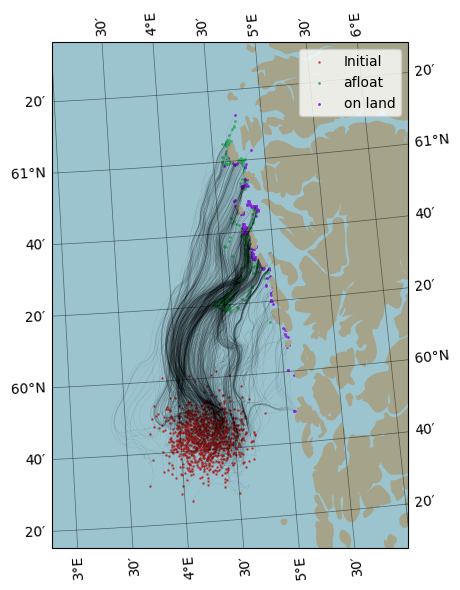

In [ ]:
args = [(3, 6, 59.25, 61.5)]

mean_x = np.array([250000])
mean_y = np.array([460000])

E = plottingFunction(1, args, 1000, 3600, 3600*24*3, 10000, mean_x, mean_y, HeunWithStop)[0]

Figure n: Plot showing the movement of particles over 3 days, taking into account stranding of particles. The green dots indicate stranded particles, while the orange dots indicate particles still afloat

Text(0, 0.5, 'Percentage of stranded particles')

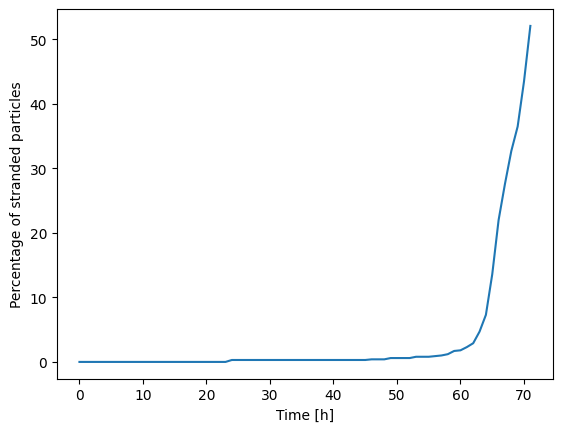

In [ ]:

num_stranded = np.zeros(E.shape[-1])
for i in range(E.shape[-1]):
    num_stranded[i] = np.count_nonzero(f.on_land(E[:,:,i]))

plt.plot(num_stranded/E.shape[1]*100)
plt.xlabel('Time [h]')
plt.ylabel('Percentage of stranded particles')

Figure n: Plot showing the number of stranded particles as a function of time. 

We see that, as intuition would suggest, the longer the particles move, the more likely they are to hit land.

3b) Another factor that affects whether or not the particles reach the shore, is the wind and the windage factor of the particle. This is a factor relating the effect of the wind on the particle to the effect of water currents. Simulating particle drifts from the same initial positions while varying $f_w$ gives insight into what happens with increased contribution of the wind.

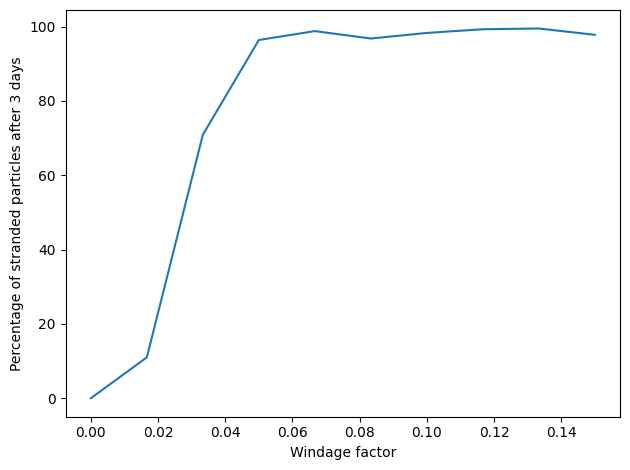

In [ ]:
# Try different windage factors and how they affect results, for example
# percentage of stranded after three days as function of f_w.

f_w_arr = np.linspace(0, 0.15, 10)
stranded_arr = np.zeros(f_w_arr.shape)

X = np.zeros((2, 1000))
X[0,:] = np.random.normal(loc=mean_x[0], scale=10000, size=1000)
X[1,:] = np.random.normal(loc=mean_y[0], scale=10000, size=1000)

for i, f_w in enumerate(f_w_arr):
    g = Interpolator(dataset = d, fw = f_w)
    E = HeunWithStop(3600,3600*3*24,X, g)
    num_stranded = np.count_nonzero(f.on_land(E[:,:,-1]))
    
    stranded_arr[i] = num_stranded

plt.plot(f_w_arr, stranded_arr/X.shape[1]*100)
plt.xlabel('Windage factor')
plt.ylabel('Percentage of stranded particles after 3 days')
plt.tight_layout()

Figure n: The function of stranded particles with regards to the windage factor. 

As the windage factor increases, the number of stranded particles increases accordingly, with the largest increase when $f_w \approx 0.03$ Thus, it seems that the wind is pulling the particles towards the shore. To further examine if this is the case, we can plot the direction of the wind as a vector field to see if it pushes the objects towards land.

In this project, a numerical model for analyzing plastics moving in water, namely the Lagrangian particle model, was examined. Initially, a theoretical test case was used to establish the relation between simulation intervals and time steps. A method for plotting the particle trajectories was implemented, and an approximate runtime analyis was performed. 

Kilde